# IMDb vs. Rotten Tomatoes: Predicting IMDb Ratings with Machine Learning

# Introduction
"Are IMDb and Rotten Tomatoes scores consistent with each other? Can one predict a movie's IMDb score using public metadata like Rotten Tomatoes ratings, genre, or runtime?"

In this notebook, we explore the relationship between IMDb and Rotten Tomatoes (RT) ratings and build a supervised machine learning model to predict a movie's IMDb score using features such as:
- Rotten Tomatoes rating
- Metacritic rating
- Runtime (in minutes)
- Release year (converted to decade)
- Oscar-winning status
- Genre (transformed using one-hot encoding)

This is a **regression problem**, as we aim to predict a continuous target: IMDb rating (range 0 to 10).

---

In [110]:
# Importing Libraries
# We begin by importing the necessary libraries for data handling, visualization, and machine learning.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

sns.set(style="whitegrid")

In [111]:
# Load Dataset
#The dataset is in JSON format and contains metadata of 250 popular movies.

with open("movies-250.json", "r", encoding="utf-8") as f:
    data = json.load(f)
movies = data["movies"]
df = pd.DataFrame(movies)
df.head()



,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response
0,The Shawshank Redemption,1994,R,14 Oct 1994,142 min,Drama,Frank Darabont,"Stephen King, Frank Darabont","Tim Robbins, Morgan Freeman, Bob Gunton",Two imprisoned men bond over a number of years...,...,81,9.3,"2,559,562",tt0111161,movie,21 Dec 1999,"$28,767,189",N/A,N/A,True
1,The Godfather,1972,R,24 Mar 1972,175 min,"Crime, Drama",Francis Ford Coppola,"Mario Puzo, Francis Ford Coppola","Marlon Brando, Al Pacino, James Caan",The aging patriarch of an organized crime dyna...,...,100,9.2,"1,765,414",tt0068646,movie,11 May 2004,"$136,381,073",N/A,N/A,True
2,The Dark Knight,2008,PG-13,18 Jul 2008,152 min,"Action, Crime, Drama",Christopher Nolan,"Jonathan Nolan, Christopher Nolan, David S. Goyer","Christian Bale, Heath Ledger, Aaron Eckhart",When the menace known as the Joker wreaks havo...,...,84,9.1,"2,528,462",tt0468569,movie,09 Dec 2008,"$534,987,076",N/A,N/A,True
3,The Godfather: Part II,1974,R,18 Dec 1974,202 min,"Crime, Drama",Francis Ford Coppola,"Francis Ford Coppola, Mario Puzo","Al Pacino, Robert De Niro, Robert Duvall",The early life and career of Vito Corleone in ...,...,90,9.0,"1,222,153",tt0071562,movie,24 May 2005,"$47,834,595",N/A,N/A,True
4,12 Angry Men,1957,Approved,10 Apr 1957,96 min,"Crime, Drama",Sidney Lumet,Reginald Rose,"Henry Fonda, Lee J. Cobb, Martin Balsam",The jury in a New York City murder trial is fr...,...,96,9.0,"756,234",tt0050083,movie,04 Mar 2008,N/A,N/A,N/A,True


In [112]:
# Extract Ratings and Clean Key Columns
# We define helper functions to extract numeric scores from nested structures.

def extract_rating(ratings, source):
    for r in ratings:
        if r["Source"] == source:
            if "%" in r["Value"]:
                return float(r["Value"].replace("%", ""))
            elif "/" in r["Value"]:
                return float(r["Value"].split("/")[0])
    return None

# Extract scores
df["RT_Rating"] = df["Ratings"].apply(lambda r: extract_rating(r, "Rotten Tomatoes"))
df["Metacritic"] = df["Ratings"].apply(lambda r: extract_rating(r, "Metacritic"))
df["imdbRating"] = pd.to_numeric(df["imdbRating"], errors="coerce")

In [113]:
# Feature Engineering
# Now we enrich and transform the data for machine learning use.

# Convert runtime to numeric
if "Runtime" in df.columns:
    df["Runtime"] = df["Runtime"].str.replace(" min", "")
    df["Runtime"] = pd.to_numeric(df["Runtime"], errors="coerce")

# Convert year to decade
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["Decade"] = (df["Year"] // 10) * 10

# Create binary Oscar feature
def won_oscar(awards):
    if pd.isna(awards): return 0
    return int("Won" in awards and "Oscar" in awards)
df["Won_Oscar"] = df["Awards"].apply(won_oscar)
# Create separate genre columns for model and visualization
# This ensures the original label remains for plotting, and encoded values are used for ML

# Text label for plots
df["MainGenre_Label"] = df["Genre"].str.split(",").str[0].str.strip()
# Copy to another column for encoding
df["MainGenre_ForModel"] = df["MainGenre_Label"]

# One-hot encode genre
df = pd.get_dummies(df, columns=["MainGenre_ForModel"], drop_first=True)


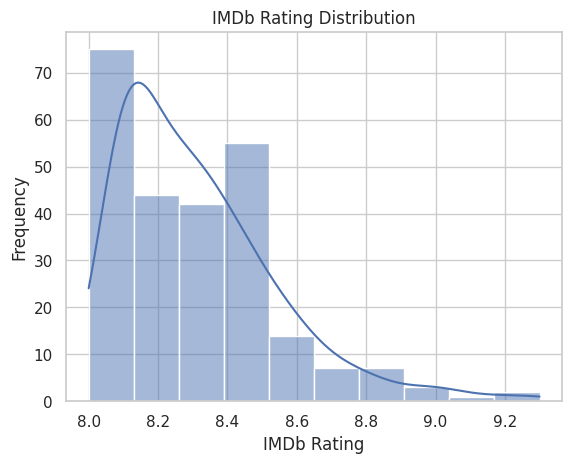

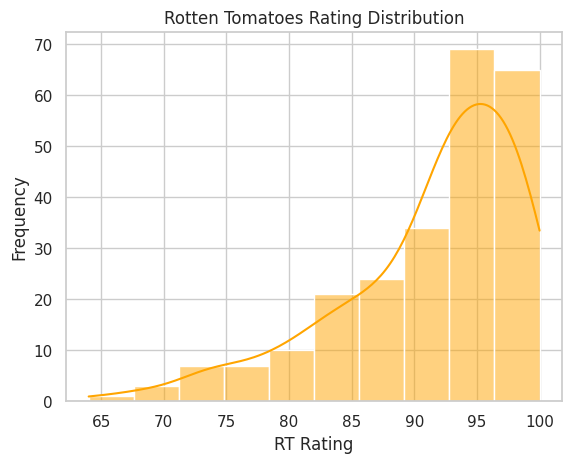

In [114]:
# Exploratory Data Analysis (EDA)
# Histogram of IMDb and RT ratings

sns.histplot(df["imdbRating"], kde=True, bins=10)
plt.title("IMDb Rating Distribution")
plt.xlabel("IMDb Rating")
plt.ylabel("Frequency")
plt.show()

sns.histplot(df["RT_Rating"], kde=True, color="orange", bins=10)
plt.title("Rotten Tomatoes Rating Distribution")
plt.xlabel("RT Rating")
plt.ylabel("Frequency")
plt.show()


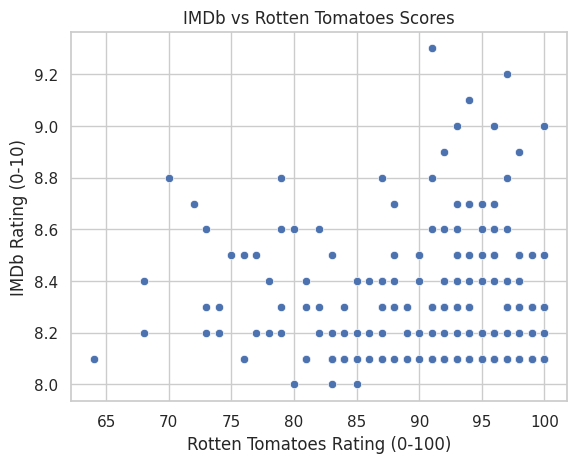

In [115]:
# Scatter plot IMDb vs RT
sns.scatterplot(x="RT_Rating", y="imdbRating", data=df)
plt.title("IMDb vs Rotten Tomatoes Scores")
plt.xlabel("Rotten Tomatoes Rating (0-100)")
plt.ylabel("IMDb Rating (0-10)")
plt.grid(True)
plt.show()

In [116]:
# Correlation
temp_df_corr = df[["imdbRating", "RT_Rating"]].dropna()
corr = temp_df_corr["imdbRating"].corr(temp_df_corr["RT_Rating"])
print(f"Pearson correlation between IMDb and RT_Rating (after dropping NaNs for this calculation): {corr:.2f}")


Pearson correlation between IMDb and RT_Rating (after dropping NaNs for this calculation): -0.01


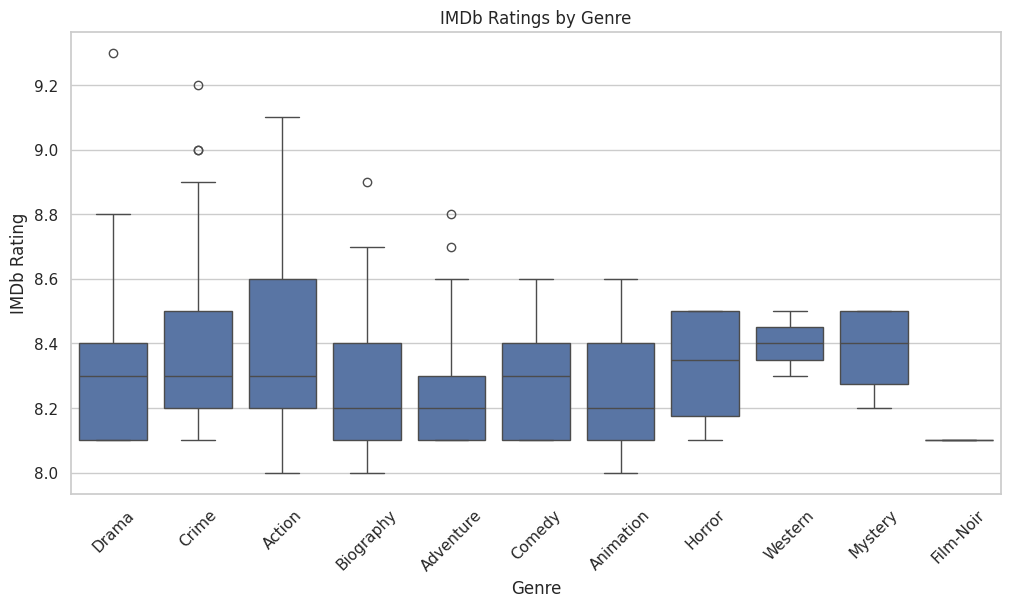

In [117]:
# Genre-based boxplot
plt.figure(figsize=(12,6))
sns.boxplot(x="MainGenre_Label", y="imdbRating", data=df)
plt.xticks(rotation=45)
plt.title("IMDb Ratings by Genre")
plt.xlabel("Genre")
plt.ylabel("IMDb Rating")
plt.show()


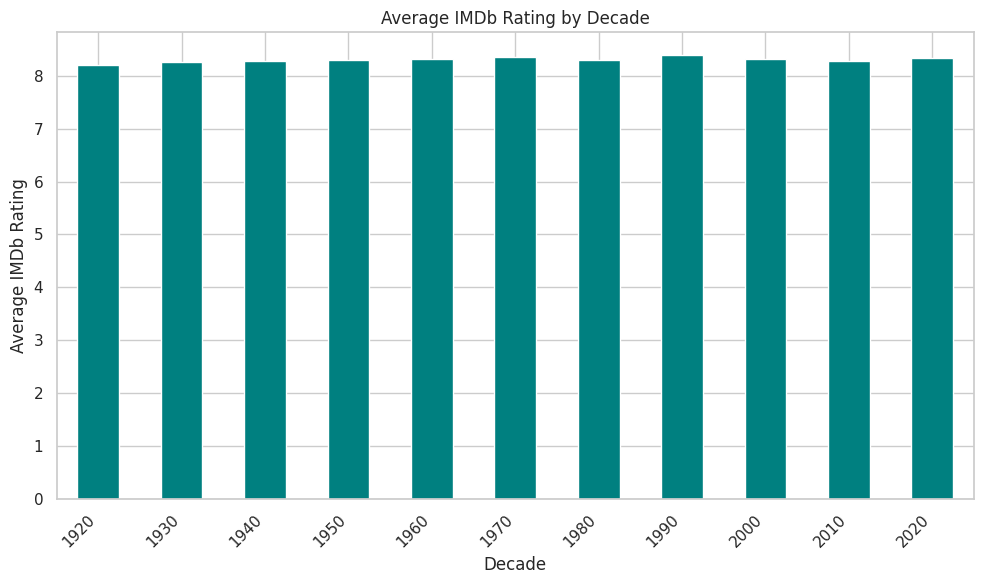

In [118]:
# Decade-based average IMDb
plt.figure(figsize=(10, 6))
df.groupby("Decade")["imdbRating"].mean().plot(kind='bar', color='teal')
plt.title("Average IMDb Rating by Decade")
plt.xlabel("Decade")
plt.ylabel("Average IMDb Rating")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Machine Learning: Predicting IMDb Score

We apply a supervised machine learning model — Random Forest Regressor — to predict IMDb scores based on a variety of enriched and transformed features, including:

- Rotten Tomatoes score
- Metacritic score
- Runtime
- Decade (from year)
- Oscar award status (binary)
- Main genre (one-hot encoded)


In [119]:
# Define Features and Target Variable

feature_cols = ["RT_Rating", "Metacritic", "Runtime", "Decade", "Won_Oscar"] + \
               [col for col in df.columns if col.startswith("MainGenre_ForModel_")]
X = df[feature_cols].dropna()
y = df.loc[X.index, "imdbRating"]

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [120]:
# Train Random Forest Regressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) first
mse = mean_squared_error(y_test, y_pred)
# Calculate Root Mean Squared Error (RMSE) by taking the square root of MSE
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("RMSE:", round(rmse, 3))
print("R²:", round(r2, 3))

RMSE: 0.217
R²: -0.448


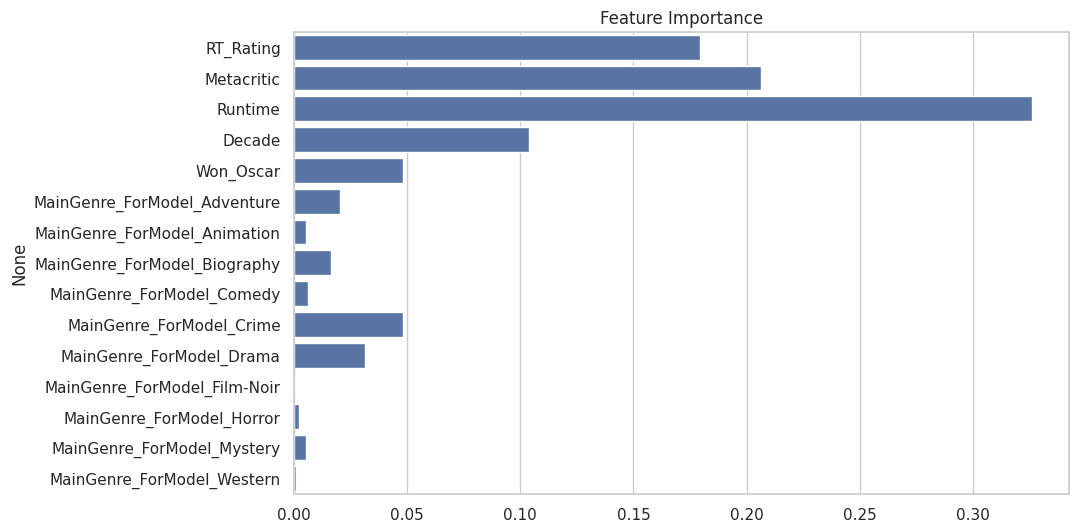

In [121]:
# Feature Importance

importances = model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()


In [122]:
# (Optional) Model Optimization with GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20]
}
grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=3)
grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)

# Re-evaluate with best model
y_pred_best = grid.predict(X_test)

# Calculate Mean Squared Error (MSE) first
mse_tuned = mean_squared_error(y_test, y_pred_best)
# Calculate Root Mean Squared Error (RMSE) by taking the square root of MSE
rmse_tuned = np.sqrt(mse_tuned)

print("Tuned RMSE:", round(rmse_tuned, 3))
print("Tuned R²:", round(r2_score(y_test, y_pred_best), 3))

Best Params: {'max_depth': 20, 'n_estimators': 100}
Tuned RMSE: 0.223
Tuned R²: -0.523


# Conclusion
- IMDb scores in this dataset are tightly clustered, making prediction challenging.
- A classification approach (e.g., high vs. low IMDb) could be more appropriate for such limited data.
- Additional features such as number of reviews, user sentiment, or budget might help.
- Feature transformation (genre, awards) helped improve model quality.
- Future work could include additional metadata (e.g., budget, release month) or using classification models.
